The notebook uses pyWPH version 1.0

In [1]:
! pip install pywph==1.0

Reason for being yanked: Wrong requirements.


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pywph as pw
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import time
import scipy.optimize as opt

In [3]:
# importing files from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
nbody = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')

(15000, 256, 256)
(256, 256)


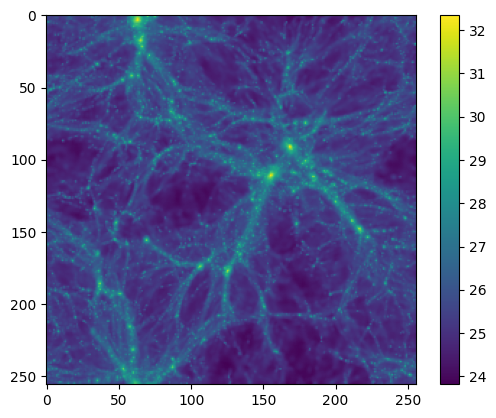

In [72]:
data = np.log(nbody[0])
print(nbody.shape)
print(data.shape)

plt.imshow(data)
plt.colorbar()


In [73]:
M = 256
N = 256
J = 7
L = 4
dn =0

wph_op = pw.WPHOp(M, N, J, L=L, dn=dn) # operator
coeff = wph_op(data) # get coefficients

In [74]:
print(coeff.shape)

torch.Size([520])


In [75]:
# run on a GPU device
if torch.cuda.is_available():
    wph_op.to(0)

In [76]:
wph = wph_op(data, ret_wph_obj=True) # WPH object
print(wph)
# easier to get coefficients

In [77]:
# obtain coefficients and their corresponding indices
s11, s11_in = wph.get_coeffs("S11")
s00, s00_in = wph.get_coeffs("S00")
s01, s01_in = wph.get_coeffs("S01")
c01, c01_in = wph.get_coeffs("C01")
cphase,cphase_in = wph.get_coeffs("Cphase")

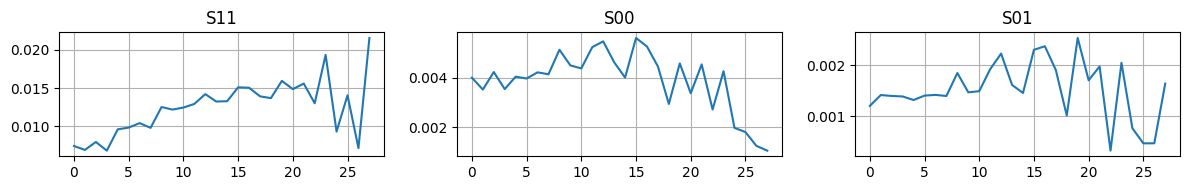

In [78]:
# s coefficients
fig, axs = plt.subplots(1, 3, figsize=(12, 2))

axs[0].plot(s11)
axs[1].plot(s00)
axs[2].plot(s01)

axs[0].set_title('S11')
axs[1].set_title('S00')
axs[2].set_title('S01')
axs[0].grid()
axs[1].grid()
axs[2].grid()

fig.tight_layout()
fig.show()

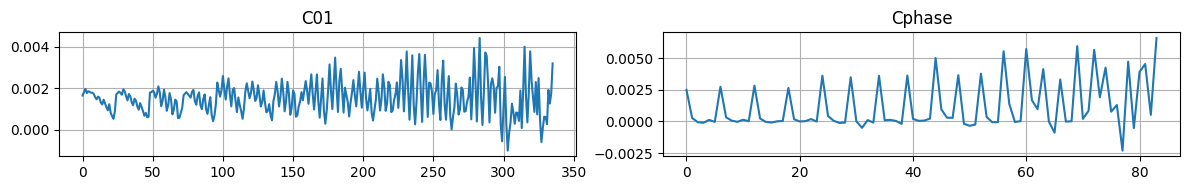

In [79]:
# c coefficients
fig, axs = plt.subplots(1, 2, figsize=(12, 2))
axs[0].plot(c01)
axs[1].plot(cphase)

axs[0].set_title('C01')
axs[1].set_title('Cphase')
axs[0].grid()
axs[1].grid()

fig.tight_layout()
fig.show()

In [80]:
# generate a noise image as an initial guess
guess = np.random.normal(data.mean(), data.std(), data.shape)

coeff = wph_op(data,norm='auto') # normalise data coefficients
print(coeff.shape)

torch.Size([520])


In [81]:
# optimizer

count = 0

def objective(y):
    global count
    print(f"Evaluation: {count}")
    start_time = time.time()
    loss_tot = torch.zeros(1)

    Y = y.reshape((M, N)) # reshape y

    # calculate loss
    Y, chunks = wph_op.preconfigure(Y, requires_grad=True)
    for i in range(chunks):
        y_coeffs_chunk, indices = wph_op(Y, i, norm='auto', ret_indices=True) # get coefficients and indice
        loss = torch.sum(torch.abs(y_coeffs_chunk - coeff[indices])** 2) # compute residual
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del y_coeffs_chunk, indices, loss

    y_final = Y.grad.cpu().numpy().astype(y.dtype) # reshape gradient
    print(f"Loss: {loss_tot.item()} (computed in {(time.time() - start_time):.2f}s)")
    count += 1
    return loss_tot.item(), y_final.ravel()


In [82]:
# run optimizer
# max number of iterations: 80
result = opt.minimize(objective, guess.ravel(), method='L-BFGS-B', jac=True, tol=None, options={"maxiter": 50, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
final_loss, final_guess, niter, msg = result['fun'], result['x'], result['nit'], result['message']
final_guess = final_guess.reshape(guess.shape)
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")

Evaluation: 0
Loss: 1032.258544921875 (computed in 7.48s)
Evaluation: 1
Loss: 1010.5084228515625 (computed in 7.58s)
Evaluation: 2
Loss: 925.5942993164062 (computed in 7.02s)
Evaluation: 3
Loss: 643.5200805664062 (computed in 7.65s)
Evaluation: 4
Loss: 157.3781280517578 (computed in 7.14s)
Evaluation: 5
Loss: 88.71614074707031 (computed in 7.78s)
Evaluation: 6
Loss: 57.4866828918457 (computed in 6.60s)
Evaluation: 7
Loss: 46.70330810546875 (computed in 7.91s)
Evaluation: 8
Loss: 36.874755859375 (computed in 6.98s)
Evaluation: 9
Loss: 29.633087158203125 (computed in 8.00s)
Evaluation: 10
Loss: 27.5175724029541 (computed in 6.97s)
Evaluation: 11
Loss: 12.168447494506836 (computed in 7.93s)
Evaluation: 12
Loss: 32.043907165527344 (computed in 6.87s)
Evaluation: 13
Loss: 9.942302703857422 (computed in 8.00s)
Evaluation: 14
Loss: 9.004777908325195 (computed in 6.88s)
Evaluation: 15
Loss: 6.1822099685668945 (computed in 8.01s)
Evaluation: 16
Loss: 4.17790412902832 (computed in 6.87s)
Evaluat

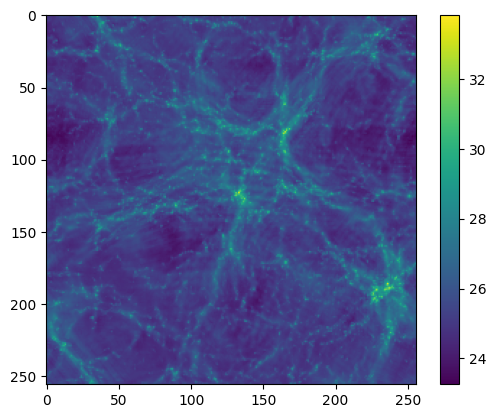

In [83]:
#
plt.imshow(final_guess)
plt.colorbar()

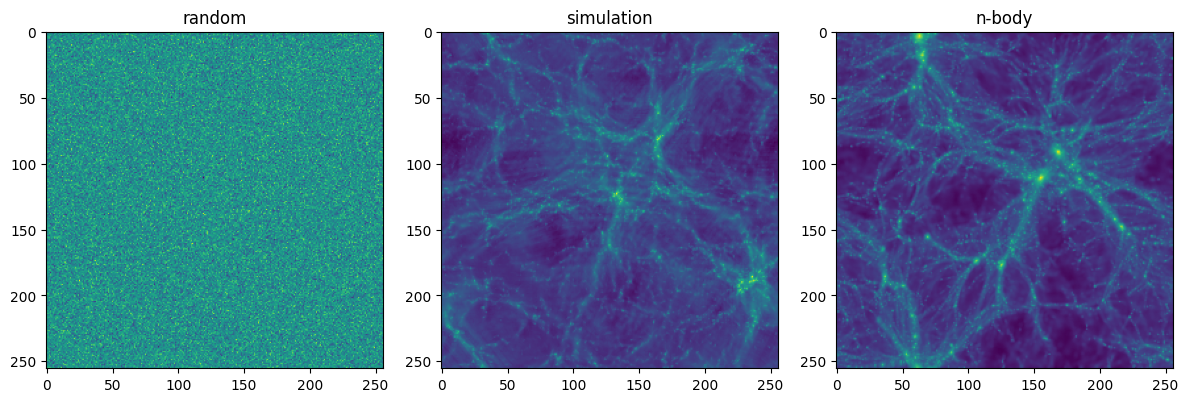

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(12, 12))

axs[0].imshow(guess)
axs[1].imshow(final_guess)
axs[2].imshow(data)

axs[0].set_title('random')
axs[1].set_title('simulation')
axs[2].set_title('n-body')

fig.tight_layout()
fig.show()

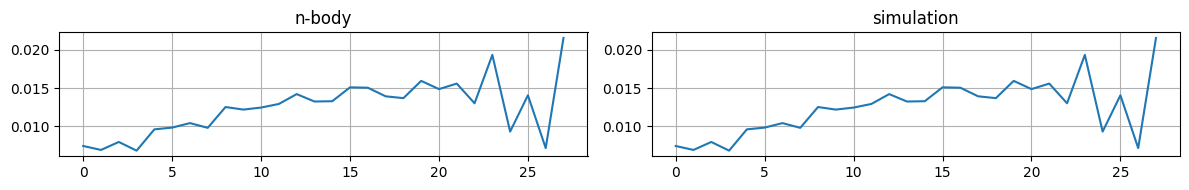

In [86]:
# compare s11 coefficients

wph1 = wph_op(final_guess, ret_wph_obj=True) # WPH object
s11_guess, s11_in_guess = wph.get_coeffs("S11")

fig, axs = plt.subplots(1, 2, figsize=(12, 2))
axs[0].plot(s11)
axs[1].plot(s11_guess)
axs[0].set_title('n-body')
axs[1].set_title('simulation')
axs[0].grid()
axs[1].grid()

fig.tight_layout()
fig.show()
